#  使用原子卷积网络建立蛋白质配体相互作用模型
By [Nathan C. Frey](https://ncfrey.github.io/) | [Twitter](https://twitter.com/nc_frey) and [Bharath Ramsundar](https://rbharath.github.io/) | [Twitter](https://twitter.com/rbhar90)

本 DeepChem 教程要介绍 [原子卷积神经网络（Atomic Convolutional Neural Network, ACNN](https://arxiv.org/pdf/1703.10603.pdf)。我们将看到 `AtomicConvModel` 的架构，并编写一个简单的程序来运行原子卷积（Atomic Convolutions）。

## 背景知识：

在数学中，一个距离矩阵是一个包含一组点两两之间距离的矩阵(即 二维数组)。因此给定N个欧几里得空间中的点，其距离矩阵就是一个非负实数作为元素的N×N的对称矩阵。这些点两两之间点对的数量，N×(N-1)/2，也就是距离矩阵中独立元素的数量。—— [百度百科](https://baike.baidu.com/item/%E8%B7%9D%E7%A6%BB%E7%9F%A9%E9%98%B5/8253120?fr=aladdin)

邻近列表程序（neighbor list routine）：基本思路是，把一个分子放在一个长方体容器，然后容器被分割成许多小的盒子，最后某个小盒子内的原子的邻近列表由这个小盒子附近的小盒子内的全部原子组成。详细的介绍如下：

1. 首先确定容器的长，宽，高。
2. 然后以固定的长度分割容器，比如：有个正方体容器，边为40埃，每边分成八份，因此总共有8*8*8=512个小盒子，每一个盒子的边长为5埃，最后给每个小盒子制定坐标。比如：把最左边，最下面，最前面的小盒子的坐标设为(1,1,1)，那么、最右边，最上面，最后面的小盒子坐标为(8,8,8)
3. 然后根据每个原子的正交坐标系坐标确定每个小盒子中的原子，我们可以把这些数据保存在一个(x,y,z,i)的四维数列中，其中x,y,z是原子所在的小盒子的坐标（如上面所述），i为原子编号。
4. 上面所述的四维数列，最开始以源自编号排序的，后面根据原子所在的小盒子坐标(x,y,z)排升序。
5. 人为的给定某个范围，分子中某个原子的邻近列表是上面所述的排序好的四维数列中围绕着这个原子的所给定范围内的所有原子。

通过上述过程，我们就能得到分子中某个原子的邻近列表。也就是说，某个原子的邻近列表是这个原子所在的小盒子附近的小盒子中的所有原子。当然，“附近”的定义取决于你。我们使用这种程序是因为，这个程序的运行时间短，跟总共原子数乘以M成正比。（这里的M指的是上面所述的范围）。用公式表示的话：O(NM)（N是总原子数）。

参考文献：https://doi.org/10.1002/jcc.540100709

### ACNN 架构
ACNN 直接利用分子的局部三维结构，通过端到端同时优化模型和特征化，分层学习更复杂的化学特征。

原子卷积利用邻近列表距离矩阵从不一定包含空间局部性的输入表示(笛卡尔原子坐标)中提取具有局部化学环境的特征。以下方法用于构建ACNN架构:

- __距离矩阵__  
距离矩阵 $R$ 是由笛卡尔原子坐标 $X$ 构造的。它计算距离张量 $D$ 的距离。距离矩阵构造接受 $(N, 3)$ 坐标矩阵 $C$ 作为输入。这个矩阵被“邻近列表”成 $(N, M)$ 矩阵 $R$。

```python
    R = tf.reduce_sum(tf.multiply(D, D), 3)     # D: Distance Tensor
    R = tf.sqrt(R)                              # R: Distance Matrix
    return R
```

- **原子卷积**  
原子卷积的输出由距离矩阵 $R$ 和原子序数矩阵 $Z$ 构造。矩阵 $R$ 被送入到步数（stride）为1、深度为 $N_{at}$ 的 (1x1) 过滤器（filter），其中 $N_{at}$ 是分子系统中存在的唯一原子序数(原子类型)的数量。原子卷积核是一个作用于邻近距离矩阵 $R$ 的阶跃函数。

- **辐射池化层（Radial Pooling layer）**  
辐射池化基本上是一个降维过程，对原子卷积的输出进行降采样。降维过程通过特征分类提供一种抽象的表示形式，以及减少需要学习的参数数量，从而防止过拟合。
从数学上讲，辐射池化层在大小为 (1x $M$ x1)、步数为1、深度为 $N_r$ 的张量切片(接受域)上进行池化，其中 $N_r$ 是所需辐射过滤器的数量， $M$ 是邻近范围。

- **原子全连接网络（Atomistic fully connected network）**  
原子卷积层通过将扁平的辐射池化层输出 （$N$, $N_{at}$ $\cdot$ $N_r$）输入到原子卷积进行堆叠。最后，我们将张量按行(按原子)输入到一个完全连接的网络中。对于给定分子中的每个原子，使用相同的全连接权重和偏置。

现在我们已经了解了 ACNN 的架构概述，我们将尝试更深入地研究模型，看看如何训练它，以及我们期望的输出是什么。

对于训练，我们将使用公开可用的 PDBbind 数据集。在这个例子中，每一行表示一个蛋白质-配体复合物，目标结果是配体与复合物中蛋白质的结合亲和力 ($K_i$) 。

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Modeling_Protein_Ligand_Interactions_With_Atomic_Convolutions.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!/usr/local/bin/conda info -e

In [ ]:
!/usr/local/bin/conda install -c conda-forge pycosat mdtraj pdbfixer openmm -y -q  # needed for AtomicConvs

In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

In [ ]:
import deepchem as dc
import os

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from rdkit import Chem

from deepchem.molnet import load_pdbbind
from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer

### 获取蛋白质配体数据
如果你已经完成了关于建立蛋白质-配体相互作用模型的 [教程 13](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Modeling_Protein_Ligand_Interactions.ipynb) ，你就已经熟悉了如何从 PDBbind 获得一组数据来训练我们的模型。由于我们在 [上一篇教程]((https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Modeling_Protein_Ligand_Interactions.ipynb)) 中详细探讨了分子复合物，这次我们将简单地初始化一个 `AtomicConvFeaturizer` 并直接使用 MolNet 加载 PDBbind 数据集。

In [ ]:
f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
max_num_neighbors = 12  # maximum number of spatial neighbors for an atom

acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      neighbor_cutoff=4)

`load_pdbbind` 允许我们指定是要使用整个蛋白质还是只使用结合口袋 （ `pocket=True` ）进行特征化。只使用口袋节省内存和加快特征化。我们还可以使用由约200个高质量复合物组成的“核心（core）”数据集来快速测试我们的模型，或者使用更大的由近5000个复合物组成的的“精炼（refined）”集来实现更多的数据点和更严谨的训练/验证。在Colab上，只需要一分钟就可以特征化核心  PDBbind 数据集！这是非常不可思议的，这意味着你可以快速地试验不同的特征化和模型架构。

In [ ]:
%%time
tasks, datasets, transformers = load_pdbbind(featurizer=acf,
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


CPU times: user 43.2 s, sys: 18.6 s, total: 1min 1s
Wall time: 1min 10s


不幸的是，如果你试图使用“精炼（refined）”数据集，就会发现有些复合物无法被特征化。要解决这个问题，除了增加 `complex_num_atoms` ，只需忽略数据集中 `x` 值为 `None` 的行即可。

In [ ]:
class MyTransformer(dc.trans.Transformer):
  def transform_array(x, y, w, ids):
    kept_rows = x != None
    return x[kept_rows], y[kept_rows], w[kept_rows], ids[kept_rows],

datasets = [d.transform(MyTransformer) for d in datasets]

In [ ]:
datasets

(<DiskDataset X.shape: (154, 9), y.shape: (154,), w.shape: (154,), ids: ['1mq6' '3pe2' '2wtv' ... '3f3c' '4gqq' '2x00'], task_names: [0]>,
 <DiskDataset X.shape: (19, 9), y.shape: (19,), w.shape: (19,), ids: ['3ivg' '4de1' '4tmn' ... '2vw5' '1w3l' '2zjw'], task_names: [0]>,
 <DiskDataset X.shape: (20, 9), y.shape: (20,), w.shape: (20,), ids: ['1kel' '2w66' '2xnb' ... '2qbp' '3lka' '1qi0'], task_names: [0]>)

In [ ]:
train, val, test = datasets

### 训练模型

现在我们已经有了数据集，让我们继续并初始化一个 `AtomicConvModel` 来进行训练。保持输入参数与 `AtomicConvFeaturizer` 中使用的相同，否则我们将得到错误。 `layer_sizes` 控制层数和网络中每个密集层的大小。我们选择这些超参数与 [原文](https://arxiv.org/pdf/1703.10603.pdf) 中使用的相同。

In [ ]:
acm = AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=12,
                      layer_sizes=[32, 32, 16],
                      learning_rate=0.003,
                      )

In [ ]:
losses, val_losses = [], []

In [ ]:
%%time
max_epochs = 50

metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
step_cutoff = len(train)//12
def val_cb(model, step):
  if step%step_cutoff!=0:
      return
  val_losses.append(model.evaluate(val, metrics=[metric])['rms_score']**2)  # L2 Loss
  losses.append(model.evaluate(train, metrics=[metric])['rms_score']**2)  # L2 Loss

acm.fit(train, nb_epoch=max_epochs, max_checkpoints_to_keep=1,
                callbacks=[val_cb])

CPU times: user 2min 41s, sys: 11.4 s, total: 2min 53s
Wall time: 2min 47s


损失曲线并不是完全平滑的，这并不奇怪，因为我们使用了154个训练和19个验证数据点。增加数据集的大小可能会有所帮助，但也需要更多的计算资源。

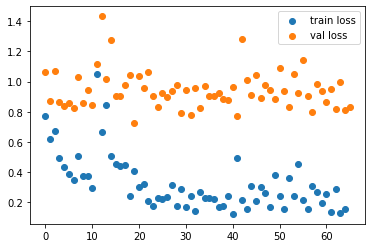

In [ ]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

[ACNN 论文](https://arxiv.org/pdf/1703.10603.pdf) 显示，pbbind 核心训练/测试集随机 80/20 拆分的 Pearson $R^2$ 分数为 0.912 和 0.448。在这里，我们使用 80/10/10 训练/验证/测试拆分，并在训练集（0.943）上实现了类似的性能。我们可以从训练、验证和测试集的表现（以及从论文的结果）看出，ACNN 可以从小型训练数据集学习化学相互作用，但难以一般化。尽管如此，我们只用几行代码就可以训练一个 `AtomicConvModel` ，并开始预测结合亲和力，这是非常令人惊讶的！

从这里开始，你可以尝试不同的超参数、更具挑战性的拆分和“精炼（refined）”的 PDBbind 数据集，以查看是否可以减少过拟合，并提出一个更严谨的模型。

In [ ]:
score = dc.metrics.Metric(dc.metrics.score_function.pearson_r2_score)
for tvt, ds in zip(['train', 'val', 'test'], datasets):
  print(tvt, acm.evaluate(ds, metrics=[score]))

train {'pearson_r2_score': 0.9311347622675604
val {'pearson_r2_score': 0.5162870575992874}
test {'pearson_r2_score': 0.4756633065901693}


### 延伸阅读
我们已经探索了 ACNN 的架构，并使用 PDBbind 数据集训练 ACNN 预测蛋白质-配体结合能。要了解更多信息，请阅读介绍 ACNN 的原始论文：Gomes, Joseph, et al. "Atomic convolutional networks for predicting protein-ligand binding affinity." [arXiv preprint arXiv:1703.10603](https://arxiv.org/abs/1703.10603) (2017)。在预测结合亲和力方面还有许多其他的方法和论文。这里有一些有趣的例子： [只用配体或蛋白质进行预测](https://www.frontiersin.org/articles/10.3389/fphar.2020.00069/full), [使用深度学习的分子对接](https://chemrxiv.org/articles/preprint/GNINA_1_0_Molecular_Docking_with_Deep_Learning/13578140), 和 [AtomNet](https://arxiv.org/abs/1510.02855)。

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!